In [1]:
import numpy as np

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq
from triqs.gf import make_gf_dlr, make_gf_dlr_imtime, make_gf_dlr_imfreq

from itertools import product

from triqs.plot.mpl_interface import oplot, plt

from gwsolver import GWSolver, GWSolverDLR


In [2]:
def get_data(G):
    if isinstance(G, BlockGf):
         return G['up']
    return G

def dlr_to_iw(G, nw):
    G_dlr = make_gf_dlr(G)
    return make_gf_imfreq(G_dlr, n_iw = nw)

def G0(spinless, mesh, t):
    g0_w = Gf(mesh=mesh, target_shape = [2, 2])
    for w in mesh:
        g0_w[w] = 0.5 *np.array([
            [1 / (w - t) + 1 / (w + t), -1 / (w - t) + 1 / (w + t)],
            [-1 / (w - t) + 1 / (w + t), 1 / (w - t) + 1 / (w + t)]
        ])
    if spinless:
        return g0_w
    else:
        return BlockGf(block_list = [g0_w] * 2, name_list = ('up', 'dn'))
    
def ifmesh(beta, statistic, nw):
    if statistic == 'Fermion':
        wmax = (2 * (nw - 1) + 1) * np.pi / beta
        return np.linspace(-wmax, wmax, 2 * nw) * 1j
    elif statistic == 'Boson':
        wmax = (2 * (nw - 1)) * np.pi / beta
        mesh_p = np.linspace(0, wmax, nw) * 1j
        mesh_m = (-np.linspace(0, wmax, nw) * 1j)[::-1]
        return np.concatenate((mesh_m[:-1], mesh_p))

In [3]:
def bool_to_str(bool):
    if bool:
        return 'Passed'
    return 'Failed'  

def compare(hartree_flag, fock_flag, spinless):
    beta = 100.0
    nw =  3 * 1024
    t = 1.0
    U = 1.5

    fmesh = MeshImFreq(beta, 'Fermion', nw)
    fmeshdlr = MeshDLRImFreq(beta, 'Fermion', w_max = 10, eps = 1e-15)

    V = np.zeros((2, 2, 2, 2))
    V[0, 0, 0, 0] = U
    V[1, 1, 1, 1] = U

    gw = GWSolver(g0_w = G0(spinless, fmesh, t), V = V, hartree_flag = hartree_flag, fock_flag = fock_flag)
    gw_dlr = GWSolverDLR(g0_w = G0(spinless, fmeshdlr, t), V = V, hartree_flag = hartree_flag, fock_flag = fock_flag)

    print("-----------------------------")
    print("DLR Test:")
    lines = [
        "\t Hartree flag : " + str(hartree_flag),
        "\t Fock flag : " + str(fock_flag),
        "\t spinless : " + str(spinless)
    ]
    max_length = max(line.index(':') for line in lines)
    for line in lines:
        left_part, right_part = line.split(':')
        formatted_line = f"{left_part.rstrip().ljust(max_length)} : {right_part.strip()}"
        print(formatted_line)
    print("\n")

    lines = [
        "Polarization : " + bool_to_str(np.allclose(get_data(gw.P_w).data, get_data(dlr_to_iw(gw_dlr.P_w, nw)).data)),
        "Screened Potential : "+ bool_to_str(np.allclose(get_data(gw.W_w).data, get_data(dlr_to_iw(gw_dlr.W_w - gw_dlr.V, nw) + gw.V).data)),
        "Self Energy : " + bool_to_str(np.allclose(get_data(gw.sigma_w).data, get_data(dlr_to_iw(gw_dlr.sigma_w - gw_dlr.hartree - gw_dlr.fock, nw) + gw.hartree + gw.fock).data)),
        "GW Green function : "  + bool_to_str(np.allclose(get_data(gw.g_w).data, get_data(dlr_to_iw(gw_dlr.g_w, nw)).data))
    ]
    max_length = max(line.index(':') for line in lines)
    for line in lines:
        left_part, right_part = line.split(':')
        formatted_line = f"{left_part.rstrip().ljust(max_length)} : {right_part.strip()}"
        print(formatted_line)
    print("-----------------------------")
    

flags = [True, False]
for hartree_flag, fock_flag, spin_flag in product(flags, flags, flags):
    compare(hartree_flag = hartree_flag, fock_flag = fock_flag, spinless = spin_flag) 

-----------------------------
DLR Test:
	 Hartree flag  : True
	 Fock flag     : True
	 spinless      : True


Polarization        : Passed
Screened Potential  : Passed
Self Energy         : Passed
GW Green function   : Passed
-----------------------------
-----------------------------
DLR Test:
	 Hartree flag  : True
	 Fock flag     : True
	 spinless      : False


Polarization        : Passed
Screened Potential  : Passed
Self Energy         : Passed
GW Green function   : Passed
-----------------------------
-----------------------------
DLR Test:
	 Hartree flag  : True
	 Fock flag     : False
	 spinless      : True


Polarization        : Passed
Screened Potential  : Passed
Self Energy         : Passed
GW Green function   : Passed
-----------------------------
-----------------------------
DLR Test:
	 Hartree flag  : True
	 Fock flag     : False
	 spinless      : False


Polarization        : Passed
Screened Potential  : Passed
Self Energy         : Passed
GW Green function   : Passe

In [4]:
beta = 100.0
nw =  10 * 1024
t = 1.0
U = 1.5

N_fix = None

spinless = False
hartree_flag = True
fock_flag = True
fmesh = MeshImFreq(beta, 'Fermion', nw)
fmeshdlr = MeshDLRImFreq(beta, 'Fermion', w_max = 10, eps = 1e-15)

wf = ifmesh(beta, 'Fermion', nw).imag
wb = ifmesh(beta, 'Boson', nw).imag

V = np.zeros((2, 2, 2, 2))
V[0, 0, 0, 0] = U
V[1, 1, 1, 1] = U

        
gw_dlr = GWSolverDLR(g0_w = G0(spinless, fmeshdlr, t), V = V, hartree_flag = hartree_flag, fock_flag = fock_flag, N_fix = N_fix)

gw = GWSolver(g0_w = G0(spinless, fmesh, t), V = V, hartree_flag = hartree_flag, fock_flag = fock_flag, N_fix = N_fix)


wf = ifmesh(beta, 'Fermion', nw).imag
wb = ifmesh(beta, 'Boson', nw).imag

wf_dlr = [iw.imag for iw in gw_dlr.g0_w.mesh.values()]
wb_dlr = [iw.imag for iw in gw_dlr.P_w.mesh.values()]


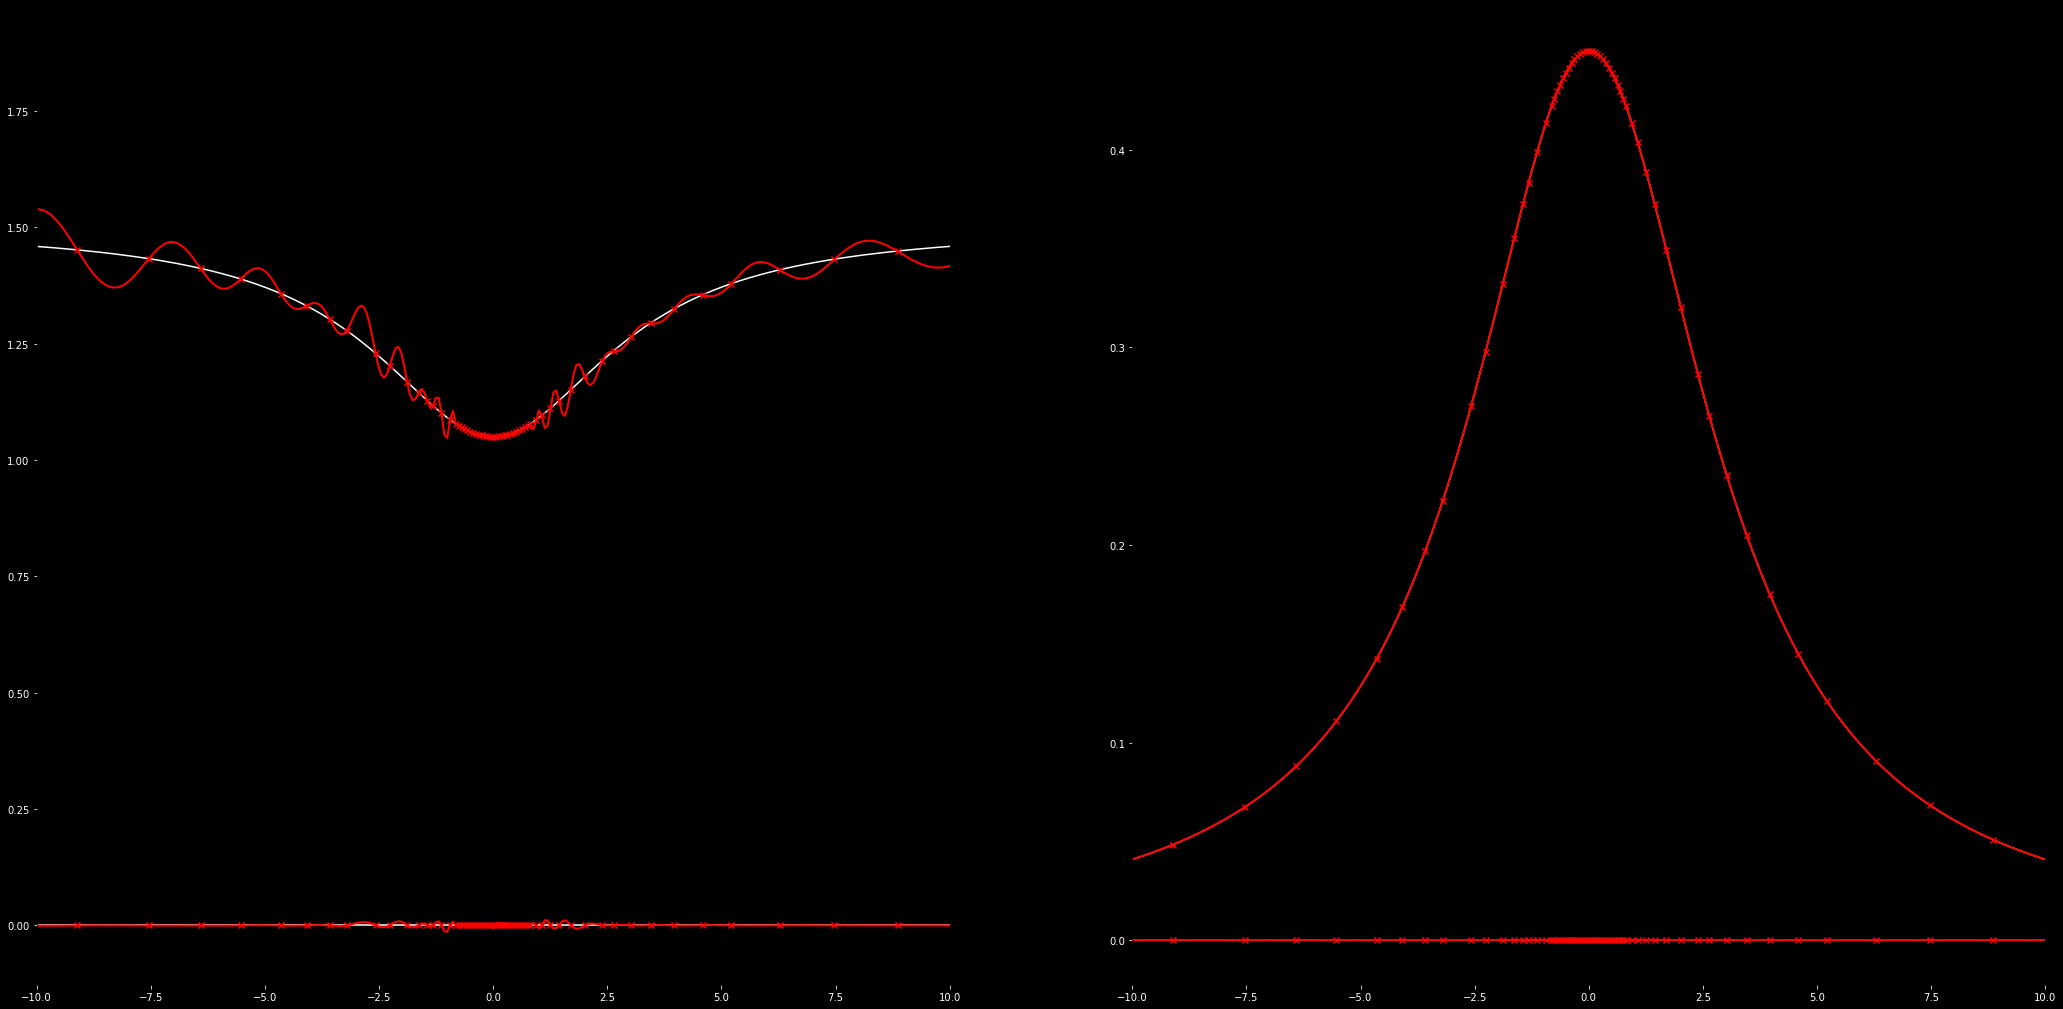

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (36, 18), facecolor = 'black')
ax1.set_facecolor('black')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis = 'x', colors = 'white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis = 'y', colors = 'white')

ax2.set_facecolor('black')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis = 'x', colors = 'white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis = 'y', colors = 'white')

ax1.set_xlim(-10, 10)

ax1.plot(wb, get_data(gw.W_w).data[:, 0, 0, 0, 0].real, color = 'white', zorder = 0)
ax1.plot(wb, get_data(gw.W_w).data[:, 0, 0, 0, 0].imag, color = 'white', zorder = 0)
ax1.scatter(wb_dlr, get_data(gw_dlr.W_w).data[:, 0, 0, 0, 0].real, color = 'red', marker = 'x', zorder = 1)
ax1.scatter(wb_dlr, get_data(gw_dlr.W_w).data[:, 0, 0, 0, 0].imag, color = 'red', marker = 'x', zorder = 1)
ax1.plot(wb, get_data(dlr_to_iw(gw_dlr.W_w, nw)).data[:, 0, 0, 0, 0].real, color = 'red', linewidth = 2, zorder = 1)
ax1.plot(wb, get_data(dlr_to_iw(gw_dlr.W_w, nw)).data[:, 0, 0, 0, 0].imag, color = 'red', linewidth = 2, zorder = 1)

ax2.set_xlim(-10, 10)
ax2.plot(wb, get_data(gw.W_w).data[:, 1, 1, 0, 0].real, color = 'white', zorder = 0)
ax2.plot(wb, get_data(gw.W_w).data[:, 1, 1, 0, 0].imag, color = 'white', zorder = 0)
ax2.scatter(wb_dlr, get_data(gw_dlr.W_w).data[:, 1, 1, 0, 0].real, color = 'red', marker = 'x', zorder = 1)
ax2.scatter(wb_dlr, get_data(gw_dlr.W_w).data[:, 1, 1, 0, 0].imag, color = 'red', marker = 'x', zorder = 1)
ax2.plot(wb, get_data(dlr_to_iw(gw_dlr.W_w, nw)).data[:, 1, 1, 0, 0].real, color = 'red', linewidth = 2, zorder = 1)
ax2.plot(wb, get_data(dlr_to_iw(gw_dlr.W_w, nw)).data[:, 1, 1, 0, 0].imag, color = 'red', linewidth = 2, zorder = 1)
plt.show()

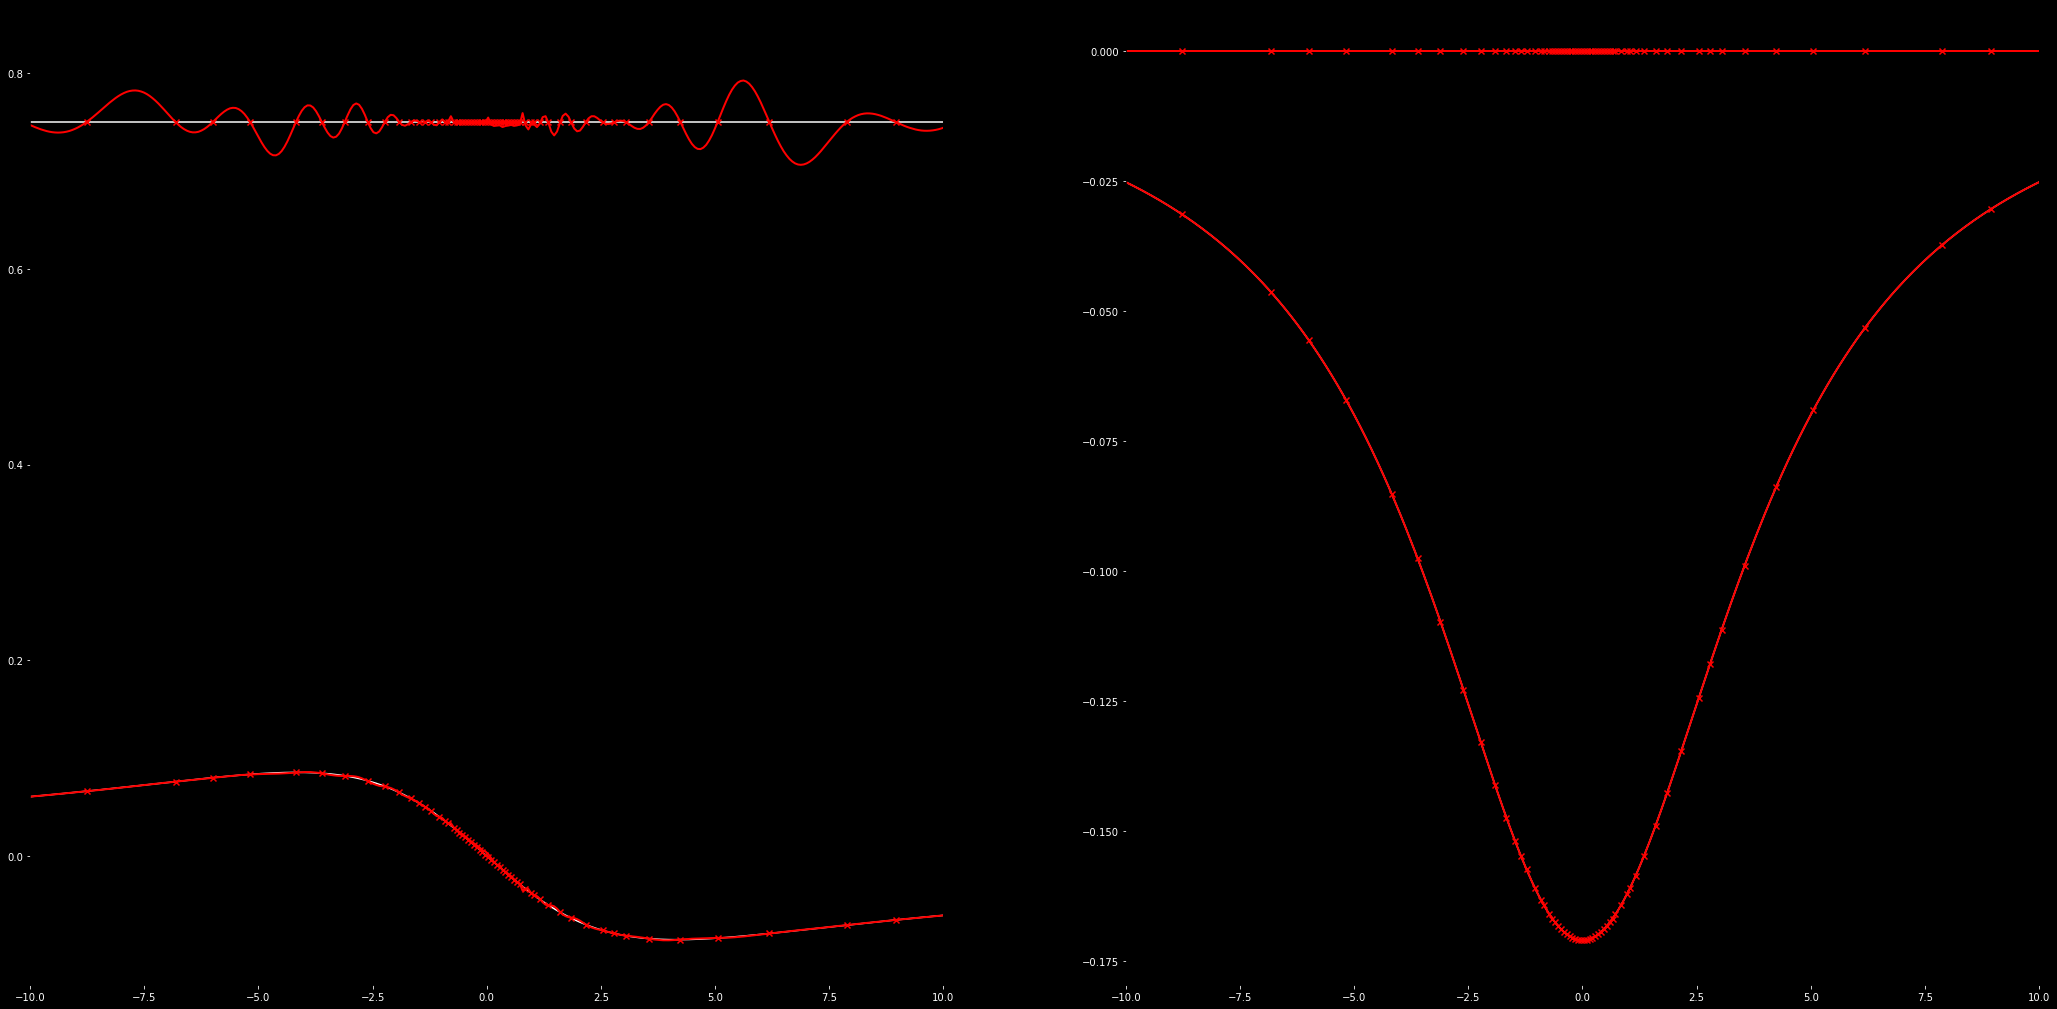

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (36, 18), facecolor = 'black')
ax1.set_facecolor('black')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis = 'x', colors = 'white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis = 'y', colors = 'white')

ax2.set_facecolor('black')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis = 'x', colors = 'white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis = 'y', colors = 'white')

ax1.set_xlim(-10, 10)

ax1.plot(wf, get_data(gw.sigma_w).data[:, 0, 0].real, color = 'white', zorder = 0)
ax1.plot(wf, get_data(gw.sigma_w).data[:, 0, 0].imag, color = 'white', zorder = 0)
ax1.scatter(wf_dlr, get_data(gw_dlr.sigma_w).data[:, 0, 0].real, color = 'red', marker = 'x', zorder = 1)
ax1.scatter(wf_dlr, get_data(gw_dlr.sigma_w).data[:, 0, 0].imag, color = 'red', marker = 'x', zorder = 1)
ax1.plot(wf, get_data(dlr_to_iw(gw_dlr.sigma_w, nw)).data[:, 0, 0].real, color = 'red', linewidth = 2, zorder = 1)
ax1.plot(wf, get_data(dlr_to_iw(gw_dlr.sigma_w, nw)).data[:, 0, 0].imag, color = 'red', linewidth = 2, zorder = 1)

ax2.set_xlim(-10, 10)
ax2.plot(wf, get_data(gw.sigma_w).data[:, 0, 1].real, color = 'white', zorder = 0)
ax2.plot(wf, get_data(gw.sigma_w).data[:, 0, 1].imag, color = 'white', zorder = 0)
ax2.scatter(wf_dlr, get_data(gw_dlr.sigma_w).data[:, 0, 1].real, color = 'red', marker = 'x', zorder = 1)
ax2.scatter(wf_dlr, get_data(gw_dlr.sigma_w).data[:, 0, 1].imag, color = 'red', marker = 'x', zorder = 1)
ax2.plot(wf, get_data(dlr_to_iw(gw_dlr.sigma_w, nw)).data[:, 0, 1].real, color = 'red', linewidth = 2, zorder = 1)
ax2.plot(wf, get_data(dlr_to_iw(gw_dlr.sigma_w, nw)).data[:, 0, 1].imag, color = 'red', linewidth = 2, zorder = 1)
plt.show()